# Case Study 2 : Data Science in Yelp Data

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [ ]:
# Case Study 2 Group 6 
# Sun, Fangzheng
# Liu, Huanhan
# Xu, Qian
# Bagul, Aashish

# In this case, we want to compare the accuracies of Textblob and two logistic regression models which could predict the stars that 
# customers would give based simply on their review contents, but not the actual stars they give.

# Since the review dataset is too large and we cannot process the whole data set in our PC, we decided to filter the most convincing 
# and useful reviews from the dataset, so we filter reviews with "useful" greater or equal to 10 in the first 1,000,000 reviews.

# Besides the stars itself, we suggest Yelp to take a look at the reviews text and improve the rating system to avoid unfair ratings. 
# (purposely high or low stars)























# Data Collection/Processing: 

In [1]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# load business file for assigned Data Expolration quesitons
import json
import io

f1=io.open('yelp_academic_dataset_business.json', encoding = 'UTF - 8')
yelp_business=[]
for line in f1:
    yelp_business.append(json.loads(line))

f2=io.open('yelp_academic_dataset_checkin.json', encoding = 'UTF - 8')
yelp_checkin=[]
for line in f2:
    yelp_checkin.append(json.loads(line))
    

# load review file for our own business problem
# load 1,000,000 reviews and filter the most convincing reviews (those with"useful" greater or equal to 10)
# numerical modules
import pandas as pd
import numpy as np
import scipy as sp

# machine learning modules
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# text processing modules
from textblob import TextBlob, Word
from nltk.stem.porter import PorterStemmer

import heapq
from collections import Counter, OrderedDict

# wordcloud visualization
from wordcloud import WordCloud

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# first transfer yelp_academic_dataset_review.json to csv file
from glob import glob

def convert(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

for json_filename in glob('yelp_academic_dataset_review.json'):
    csv_filename = '%s.csv' % json_filename[:-5]
    df = pd.DataFrame([convert(line) for line in file(json_filename)])
    df.to_csv(csv_filename, encoding='utf-8', index=False)

# then we load csv file and filter the data, saving in a data frame
yelp_review_df_before_filter = pd.read_csv('yelp_academic_dataset_review.csv', nrows = 1000000)
yelp_review_df = yelp_review_df_before_filter[(yelp_review_df_before_filter['useful'] >= 10)]



# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [2]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import operator

# count the appearance of each business category in the dataset
categories_map = {}
for line in yelp_business:
    categories = line['categories']

    try:
        for c in categories:
            if c in categories_map.keys():
                categories_map[c] = categories_map[c] + 1
            else:
                categories_map[c] = 1
    except:
        continue
            
# print keys and values of top 10 popular business categories
categories_sorted = sorted(categories_map.items(),key = operator.itemgetter(1),reverse=True)
for i in range(0,10):
    print(categories_sorted[i])


('Restaurants', 48485)
('Shopping', 22466)
('Food', 21189)
('Beauty & Spas', 13711)
('Home Services', 11241)
('Nightlife', 10524)
('Health & Medical', 10476)
('Bars', 9087)
('Automotive', 8554)
('Local Services', 8133)


** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [3]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# count the appearance of each business object in the dataset
objects_map = {}
count = 0
#count every record by category
for line in yelp_checkin:
    checkins = line['time']
    key  = line['business_id']
    temp = 0
    for checkin in checkins:
        checkin = str(checkin)
        i = checkin.find(':')
        location = i + 1
        value = int(checkin[location:])
        temp = temp + value
    objects_map[key] = temp

            
# print keys and values of top 10 popular business objects
objects_sorted = sorted(objects_map.items(),key = operator.itemgetter(1),reverse=True)
for i in range(0,10):
    print(objects_sorted[i])


('FaHADZARwnY4yvlvpnsfGA', 119204)
('JmI9nslLD7KZqRr__Bg6NQ', 101181)
('yQab5dxZzgBLTEHCw9V7_w', 44874)
('5LNZ67Yw9RD6nf4_UhXOjw', 41303)
('SMPbvZLSMMb7KU76YNYMGg', 30725)
('Wxxvi3LZbHNIDwJ-ZimtnA', 28511)
('na4Th5DrNauOv-c43QQFvA', 27213)
('El4FC8jcawUVgw_0EIcbaQ', 26506)
('VyjyHoBg3KC5BSFRlD0ZPQ', 25267)
('IZivKqtHyz4-ts8KsnvMrA', 24826)


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [ ]:
# First we filter the review data as described above and get around 10000 reviews.
# Then we convert our json file to csv file for further use. We use Textblob first to test its accuracy based on the new data frame we created.
# We go through the data again by using the two models Logistics Regression and also get their confusion matrix together with accuracies.
# Finally we compare the two logistic regressions by plotting the ROC curve. 












Write codes to implement the solution in python:

C:\Users\sun_f_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Textblob accuracy is 0.857142857143
             precision    recall  f1-score   support

          1       0.94      0.91      0.93       367
          5       0.95      0.97      0.96       662

avg / total       0.95      0.95      0.95      1029

accuracy of Bag Of Words Model: 0.948494


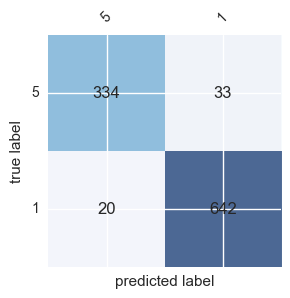

             precision    recall  f1-score   support

          1       0.94      0.80      0.86       334
          5       0.91      0.98      0.94       695

avg / total       0.92      0.92      0.92      1029

accuracy of TF-IDF Model: 0.918367


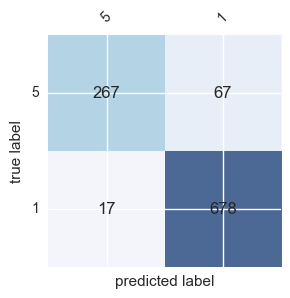

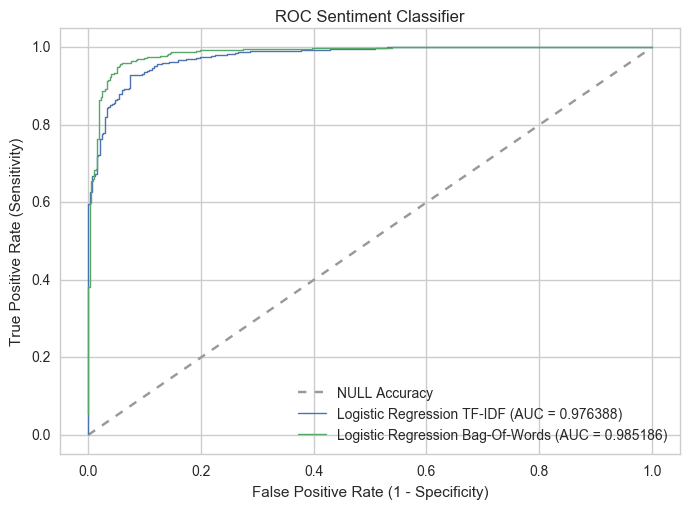

In [4]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


yelp_review_df['type'].unique()

## Drop unnecessary columns and leave only rows with stars 1 and 5

# business_id, date, user_id, type columns are irrelevant for this notebook
yelp_review_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1, inplace=True)
yelp_review_df = yelp_review_df[(yelp_review_df['stars'] == 5) | (yelp_review_df['stars'] == 1)]

# row names back to 0,1,2,...
yelp_review_df.index = range(0,len(yelp_review_df.index))

# ratio of 5-star reviews amount the 1&5-star reviews
ratio = float(len(yelp_review_df[yelp_review_df['stars'] == 5])) / (len(yelp_review_df[yelp_review_df['stars'] == 5]) + 
                                                                        len(yelp_review_df[yelp_review_df['stars'] == 1]))
# polarity ranges from -1 (most negative) to 1 (most positive)
review = TextBlob(yelp_review_df.text[0])
review.sentiment.polarity
review.sentiment.subjectivity


## Calculate Sentiment Score of Each Review with TextBlob
from textblob import *

# create a new DataFrame column for sentiment and get the sentiment scores
yelp_review_df['texblob_sentiment_score'] = yelp_review_df.text.apply(lambda x : TextBlob(x).sentiment.polarity)

# Use TextBlob to calculate stars for the reviews
yelp_review_df['textblob_predicted_stars'] = yelp_review_df['texblob_sentiment_score'].apply(lambda x : 5 if x > 0.1 else 1)

# Performance Evaluation of Textblob (accuracy)
print('Textblob accuracy is', metrics.accuracy_score(yelp_review_df['stars'], yelp_review_df['textblob_predicted_stars']))


## Sentiment Classification with Logistic Regression

# After tokenizning the string into words, we use nltk PorterStemmer to stem the tokens.
import re, nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

english_stops = stopwords.words('english')

def simple_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)    
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
   
    return tokens


def stem_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # stem
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
   
    return stems

def lemma_tokenizer(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    tokens = [elem for elem in tokens if (len(elem) > 2 and elem not in english_stops)]
    # lemmas
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
        
    return lemmas


## Method 1; Bag Of Words Model

count_vect = CountVectorizer(analyzer = 'word', tokenizer=simple_tokenizer, lowercase=True)
review_tf = count_vect.fit_transform(yelp_review_df['text'])

# Numpy arrays are easy to work with, so convert the result to an array
review_tf_nd = review_tf.toarray()

# Document Term Matrix
df = pd.DataFrame(review_tf_nd, columns=count_vect.get_feature_names())

# Words in the vocabulary
vocab = count_vect.get_feature_names()

# Predict the stars rating - A bag-of-words Linear Classifier

# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_review_df['stars'], train_size=0.75)

# Create and train the Logistic Regression Classifier
log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train, y=y_train)

# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tf_model.predict(X=X_test)
y_pred_proba = log_tf_model.predict_proba(X=X_test)[:,1]

#calculates several types of (predictive) scores on a classification model
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
print("accuracy of Bag Of Words Model: %0.6f" % metrics.accuracy_score(y_test, y_pred))

# Confusion matrix of Words Model
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test, y_pred_proba, pos_label=5)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)


## Method 2; TF-IDF Model

tfidf_vect = TfidfVectorizer(analyzer = 'word', tokenizer=lemma_tokenizer, lowercase=True)
review_tf = tfidf_vect.fit_transform(yelp_review_df.text)

# Numpy arrays are easy to work with, so convert the result to an array
review_tf_nd = review_tf.toarray()
review_tf_nd.shape

# Document Term Matrix
df = pd.DataFrame(review_tf_nd, columns=tfidf_vect.get_feature_names())

# Words in the vocabulary
vocab = tfidf_vect.get_feature_names()

# Predict the stars rating - A TF-IDF Linear Classifier

# split Train and Validation Data Set
X_train, X_test, y_train, y_test  = train_test_split(review_tf_nd, yelp_review_df['stars'], train_size=0.75)

from sklearn.linear_model import LogisticRegression
# Create and train the Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train, y=y_train)

# Use the classifier to label our evaluation set. We can use either predict for classes or predict_proba for probabilities.
y_pred = log_tfidf_model.predict(X=X_test)
y_pred_prob = log_tfidf_model.predict_proba(X=X_test)[:,1]

# compute precision and recall, or their combination (harmonic mean) F1:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
print("accuracy of TF-IDF Model: %0.6f" % metrics.accuracy_score(y_test, y_pred))

# Confusion matrix of TF-IDF Model
from pylab import rcParams
labels = ['5', '1']
confmat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.7)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks,labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=5)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)

## Compare the two methods plotting ROC curve
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression Bag-Of-Words (AUC = %0.6f)' % roc_auc_tf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


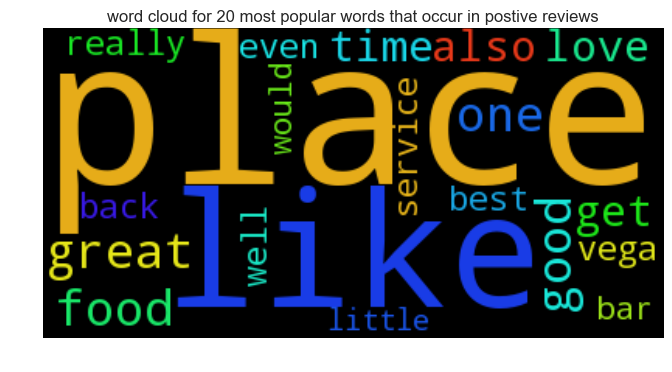

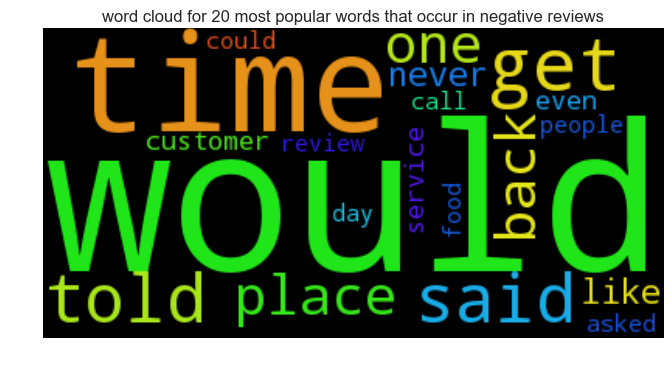

In [13]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# We do the data visulization by creating word clouds for positive and negative words. 

# calculate frequency distribution of words in positive reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 5)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count

# word cloud for 20 most popular words that occur in postive reviews
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.title("word cloud for 20 most popular words that occur in postive reviews")
plt.axis("off")
plt.imshow(wordcloud)
plt.show(wordcloud)

# calculate frequency distribution of words in negative reviews
dist = np.sum(review_tf_nd[np.where(yelp_review_df['stars'] == 1)], axis=0)

counter = Counter()
# For each, print the vocabulary word and the number of times it appears in the data set
for tag, count in zip(vocab, dist):
    counter[tag] = count

# word cloud for 20 most popular words that occur in negative reviews
wordcloud = WordCloud().fit_words(counter.most_common(20))
plt.title("word cloud for 20 most popular words that occur in negative reviews")
plt.axis("off")
plt.imshow(wordcloud)
plt.show(wordcloud)



*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 2".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


